In [ ]:
#|default_exp xrf_physics 

# Theoretical peak patterns   

> Predicting elemental XRF (X-Ray Fluorescence) spectra  

In order to unravel measured x-ray fluorescence (XRF) spectra it is essential to be able to compute the theoretical spectral emission patterns for individual elements. An XRF spectrum consists of a number of peaks whose positions/energies (expressed in kilo electron Volt) are specific for a given element. To a first approximation the intensities of the peaks are proportional the concentration of the element. However if we look with more scrutiny it turns out that the exact height proportions of the peaks varies with the thickness of the sample. Let's skip the theoretical background and simply plot such an XRF spectrum. For now, simply import `ElementXRF()` and instantiate it for lead (Pb). 

If you are interested in the physics behind this, you can find the gory details in a later section...

In [ ]:
from moseley import ElementXRF
import matplotlib.pyplot as plt 

Plotting a theoretical X-ray fluorescence spectrum can be done with the `.plot_spectrum()` method. 

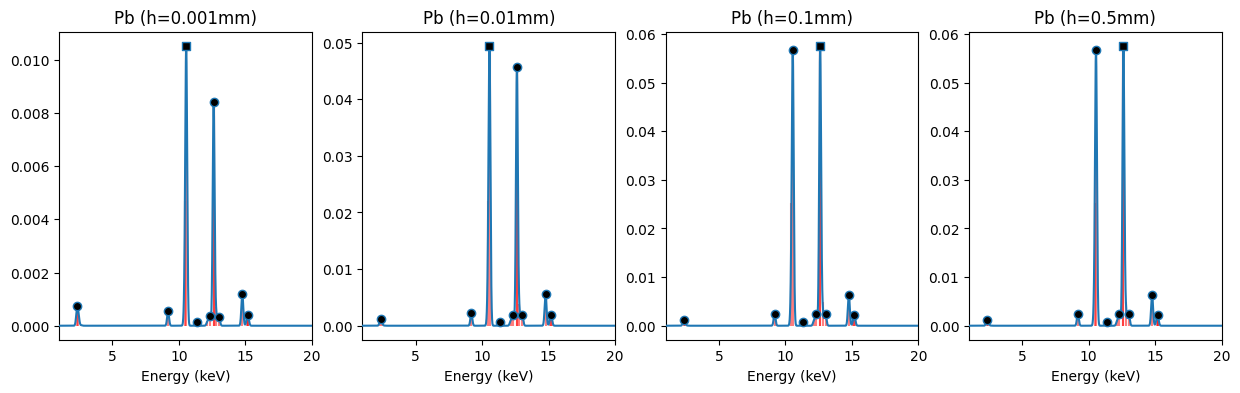

In [ ]:
# initialize plot 
fig, axs = plt.subplots(ncols=4, figsize=[15, 4], sharex=True, sharey=False)
axs = axs.flatten()

# iterate over a list of different sample thicknesses 
for h_mm, ax in zip([0.001, 0.01, 0.1, 0.5], axs):   
    Pb_xrf = ElementXRF('Pb', h_mm=h_mm) 
    Pb_xrf.plot_spectrum(facecolor='k', ax=ax, xlim=[1, 17], vlines_colors='r') 
    ax.set_title(f'Pb (h={h_mm}mm)')  
    ax.set_xlim(xmax=20)

We can see here that these spectra (blue with black markers) for lead consist of multiple Gaussian shaped peaks. Most of these peaks are the result of closely spaced emission lines (red color). Each emission line corresponds to a specific transition of an electron between different electron shells. Although these patterns for lead samples of different thicknesses look fairly similar, their precise proportions vary. 


If you want to inspect emission lines in detail you can take a look the `.lines_table` attribute.  

In [ ]:
Pb_xrf.lines_table # 0.5 mm 

,name,label,energy,trans_prob,fluo_yield,jump_coeff,attenuation,intensity
0,Lb4,Pb_L1M2,12.3070,0.338604,0.112000,0.135060,0.462812,0.002371
1,Lb3,Pb_L1M3,12.7950,0.401364,0.112000,0.135060,0.487145,0.002958
2,Lg2,Pb_L1N2,15.0991,0.114773,0.112000,0.135060,0.378123,0.000656
3,Lg3,Pb_L1N3,15.2175,0.145259,0.112000,0.135060,0.310437,0.000682
4,Ln,Pb_L2M1,11.3490,0.018116,0.373000,0.285714,0.412679,0.000797
5,Lb1,Pb_L2M4,12.6140,0.787801,0.373000,0.285714,0.478221,0.040150
6,Lg1,Pb_L2N4,14.7657,0.165149,0.373000,0.285714,0.364340,0.006412
7,Lg6,Pb_L2O4,15.1793,0.028934,0.373000,0.285714,0.381387,0.001176
8,Ll,Pb_L3M1,9.1840,0.037951,0.360000,0.600958,0.292015,0.002398
9,La2,Pb_L3M4,10.4490,0.076339,0.360000,0.600958,0.363219,0.005999


## FUNCTIONS 

In [ ]:
#|export 

import numpy as np 
import xraydb 
import pandas as pd 
import scipy.signal as ssg 
import scipy.interpolate as sip
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import mendeleev

In [ ]:
#|export 

class ElementXRF(): 
    '''Computes fluorescence emission line energies and intensities for `element`. 
    
    '''
    
    def __init__(self, element, excitation_energy_keV='rhodium_Ka', h_mm=0.1, x_keVs=None, std=0.01, min_prom=0.001): 
        '''Create a theoretical elemental xrf spectrum object. '''

        ### LINES ### 

        if excitation_energy_keV == 'rhodium_Ka': 
            excitation_energy_keV = 22.1  

        self.element = element 

        excitation_energy = 1000 * excitation_energy_keV # keV -> eV 

        lines = xraydb.xray_lines(element, excitation_energy=excitation_energy) 

        line_names = [] # Siegbahn notation
        line_labels = [] # IUPAC notation 
        line_energies = [] 
        line_probabilities = [] 

        line_fluo_yields = []
        line_jump_coeffs = [] 
        line_attenuations = [] 
        
        line_intensities = []
        
        for name, line in lines.items(): 

            # xraydb 'intensities' (a.k.a. transition probablities) sum up to unity within each level 
            emission_energy, probability, initial_level, final_level = line  
            emission_energy_keV = emission_energy / 1000  
            label = f'{element}_{initial_level}{final_level}' #  construct IUPAC notation 
            
            # get corresponding edge properties 
            edge = initial_level # IUPAC notation!  e.g. 'L1', not 'La'
            edge_energy, fluo_yield, jump_ratio = xraydb.xray_edge(element, edge) 
            jump_coeff = (jump_ratio - 1) / jump_ratio # see Volker Thomsen 

            attenuation = get_attenuation(element, emission_energy_keV, excitation_energy_keV, h_mm=h_mm)
            #print(f'{name}: {energy}; jump_coeff: {jump_coeff:.03f}; fluo_yield: {fluo_yield}')

            # multiplying edge jump coefficient, transition probability and fluorescence yield... 
            intensity = jump_coeff * probability * fluo_yield * attenuation

            line_names.append(name) 
            line_labels.append(label)
            line_energies.append(emission_energy_keV)
            line_probabilities.append(probability)  
            
            line_fluo_yields.append(fluo_yield)
            line_jump_coeffs.append(jump_coeff) 
            line_attenuations.append(attenuation) 
            
            line_intensities.append(intensity) 

        self.lines_table = pd.DataFrame({'name': line_names, 
                                         'label': line_labels, 
                                         'energy': line_energies, 
                                         'trans_prob': line_probabilities, 
                                         'fluo_yield': line_fluo_yields, 
                                         'jump_coeff': line_jump_coeffs, 
                                         'attenuation': line_attenuations, 
                                         'intensity': line_intensities}) 

    
        ### CONTINUOUS ### 
        
        self.spectrum_xy = gaussian_convolve(line_energies, line_intensities, x_keVs=x_keVs, std=std) 
        self.peaks_xy = find_peaks(*self.spectrum_xy, min_prom=min_prom) 

    def plot_spectrum(self, ax=None, edgecolor=None, facecolor=None, vlines_colors=None, xlim=[0, 25]): 
        
        if edgecolor is None: 
            edgecolor = cm.tab20(0)
        if facecolor is None: 
            facecolor = 'w' 
    
        if ax is None: 
            fig, ax = plt.subplots() 
    
        x, y = self.spectrum_xy 
        peaks_x, peaks_y = self.peaks_xy.T
    
        ax.plot(x, y, color=edgecolor, zorder=9)
        ax.scatter(peaks_x[0], peaks_y[0], marker='s', facecolor=facecolor, edgecolor=edgecolor, zorder=10)  
        ax.scatter(peaks_x[1:], peaks_y[1:], marker='o', facecolor=facecolor, edgecolor=edgecolor, zorder=10)
    
        # need to interpolate spectrum to add vlines 
    
        spectrum = sip.interp1d(x, y)
        line_keVs = self.lines_table['energy'] 
    
        line_heights = spectrum(line_keVs)
    
        ax.vlines(line_keVs, np.zeros_like(line_keVs), line_heights, colors=vlines_colors, alpha=0.5, zorder=8) 

        ax.set_title(f'Theoretical X-Ray Fluorescence for {self.element}') 
        ax.set_xlabel('Energy (keV)')
        ax.set_xlim(xlim)
        
        return ax 

    def get_pattern_dict(self): 
    
        alpha_keV = float(self.peaks_xy[0][0])
        alpha_escape_keV = alpha_keV - 1.74  # Silicon detector escape energy shift 
        
        # element   
        elem = self.element
        name = mendeleev.element(elem).name
        atomic_number = mendeleev.element(elem).atomic_number
        
        ptrn_dict = {'elem': elem,  
                     'atomic_number': atomic_number, 
                     'alpha_keV': alpha_keV, 
                     'name': name, 
                     'peaks_xy': self.peaks_xy, 
                     'alpha_escape_keV': alpha_escape_keV} 
        
        return ptrn_dict
    
#def get_element_spectra(elements, x_keVs, excitation_energy_keV): 
#   '''Compute theoretical emission spectrum for multiple elements. 
#   
#   Sorts elements according to largest (alpha) peak. Based on xraydb. 
#   
#   Returns: elements, element_spectra
#   '''
#
#   n_channels = len(x_keVs)
#   n_elements = len(elements)
#
#   element_spectra = np.zeros([n_elements, n_channels]) 
#
#   for i, elem in enumerate(elements): 
#       element_spectra[i] = get_element_spectrum(elem, excitation_energy_keV, x_keVs=x_keVs)
#
#       # normalize
#       element_spectra[i] = element_spectra[i] / element_spectra[i].max()
#
#
#   # sort according to energy of largest (=alpha) peak
#   alpha_idxs = np.argmax(element_spectra, axis=1)
#   alpha_order = np.argsort(alpha_idxs) 
#
#   elements = [elements[i] for i in alpha_order]
#   element_spectra = element_spectra[alpha_order]
#   
#   return elements, element_spectra 
#

def gaussian_convolve(peak_energies, peak_intensities, x_keVs=None, std=0.01): 
    '''Convolves line spectrum defined by `peak_energies` and `peak_intensities` 
    
    with a Gaussian peak shape.'''
    
    if x_keVs is None: 
        x_keVs = np.linspace(0, 40, 10000)

    y_spectrum = np.zeros_like(x_keVs) 

    for peak_energy, peak_intensity in zip(peak_energies, peak_intensities): 

        y_spectrum += peak_intensity * np.exp(-(1 / std) * (x_keVs - peak_energy)**2)
        
    return x_keVs, y_spectrum  

def find_peaks(x, y, min_prom=0.001):  
    '''Find peaks in spectrum `x`, `y` with minimal prominence `min_prom=`
    
    Returns: peaks_xy''' 
    
    # find the peaks (channel indexes) 
    peaks, props = ssg.find_peaks(y/y.max(), prominence=[min_prom, None])

    peaks_x = x[peaks]
    peaks_y = y[peaks] 
    
    # sort according to peak_height 
    sort_idxs = np.argsort(peaks_y)[::-1] 

    peaks_x = peaks_x[sort_idxs]
    peaks_y = peaks_y[sort_idxs]
    
    peaks_xy = np.c_[peaks_x, peaks_y]

    return peaks_xy 

def plot_pattern(ptrn_dict, ax=None, offset=0, color=None): 
    '''Plot a single element peak pattern. 
    ''' 
        
    element = ptrn_dict['elem']
    
    x, _ = ptrn_dict['peaks_xy'].T
    y = np.zeros_like(x) + offset 
    alpha_escape_keV = ptrn_dict['alpha_escape_keV']
         
    left_x = min(x)
    right_x = max(x) 

    if color is None: 
        facecolor = 'w'
        edgecolor = 'grey'
        linecolor = 'grey'
        linestyle = ':'

    else: 
        facecolor = color 
        edgecolor = 'k'
        linecolor = color
        linestyle = '-'

    if ax is None: 
        fig, ax = plt.subplots() 

    ax.scatter(x, y, s=15, facecolor=facecolor, edgecolor=edgecolor)
    ax.scatter(x[0], y[0], marker='s', facecolor=facecolor, edgecolor=edgecolor)
    ax.plot([left_x, right_x], [y[0], y[0]], color=edgecolor, linestyle=linestyle, zorder=-10)
    ax.scatter(alpha_escape_keV, y[0], marker='|', color=edgecolor) 
    ax.annotate(element, [right_x, y[0]], xytext=[5, -1], fontsize=8, color='k', 
                textcoords='offset points', ha='left', va='center') 
   
    return ax 


def get_attenuation(element, emission_energy_keV, excitation_energy_keV='rhodium_Ka', h_mm=0.1): 
    '''Attenuation factors for emissions at `emission_keVs` for pure sample with thickness `h_mm`. 

    See Thomsen_2007 equation 11. 
    
    Returns: att_list (array of floats)'''

    if excitation_energy_keV == 'rhodium_Ka': 
        excitation_energy_keV = 22.1 
        
    excitation_energy = excitation_energy_keV * 1000 
    emission_energy = emission_energy_keV * 1000 

    if emission_energy < 150: # eV 
        attenuation = 0 
        
    else: 
        mu_excit = xraydb.mu_elam(element, excitation_energy)
        mu_emiss = xraydb.mu_elam(element, emission_energy)
    
        # mathematically the thickness factor is defined as: 
        rho = xraydb.atomic_density(element)
        thickness_factor = 1 - np.exp(-rho * h_mm * 0.1 * (mu_excit + mu_emiss))
        
        attenuation = (mu_excit / (mu_excit + mu_emiss)) * thickness_factor 

    return attenuation
